In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-20-processed-version/steam_reviews_subset_20_processed_4_25.csv
/kaggle/input/steam-processed-5-new/steam_subset_5_processed_new.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

# import spacy
# spacy.prefer_gpu()
# nlp = spacy.load("en_core_web_sm")

# wordcloud 
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# cleaned and processed 20% data sample taken from steam reviews
# data = pd.read_csv("/kaggle/input/steam-20-processed-version/steam_reviews_subset_20_processed_4_25.csv")

In [4]:
# cleaned and processed 20% data sample taken from steam reviews
data = pd.read_csv("/kaggle/input/steam-processed-5-new/steam_subset_5_processed_new.csv")

In [5]:
data.head()

,app_id,app_name,review_text,review_score,review_votes,review_processed
0,237930,Transistor,I think the main thing that surprised me about...,1,0,think main thing surprise game intigration mus...
1,270450,Robot Roller-Derby Disco Dodgeball,Cute little FPS that takes a little practice t...,1,0,cute little fps take little practice learn cat...
2,49520,Borderlands 2,This game is absolutely the best! Totally wort...,1,0,game absolutely good totally worth get cheap s...
3,211400,Deadlight,"Nope, just a nope. Clunky control, I can't sa...",0,0,nope nope clunky control frustrating play ga...
4,219640,Chivalry: Medieval Warfare,I went into Chiv expecting something amazing. ...,1,0,go chiv expect amazing exactally think go ga...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195564 entries, 0 to 195563
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   app_id            195564 non-null  int64 
 1   app_name          195564 non-null  object
 2   review_text       195564 non-null  object
 3   review_score      195564 non-null  int64 
 4   review_votes      195564 non-null  int64 
 5   review_processed  195452 non-null  object
dtypes: int64(3), object(3)
memory usage: 9.0+ MB


In [7]:
data.isnull().sum()

app_id                0
app_name              0
review_text           0
review_score          0
review_votes          0
review_processed    112
dtype: int64

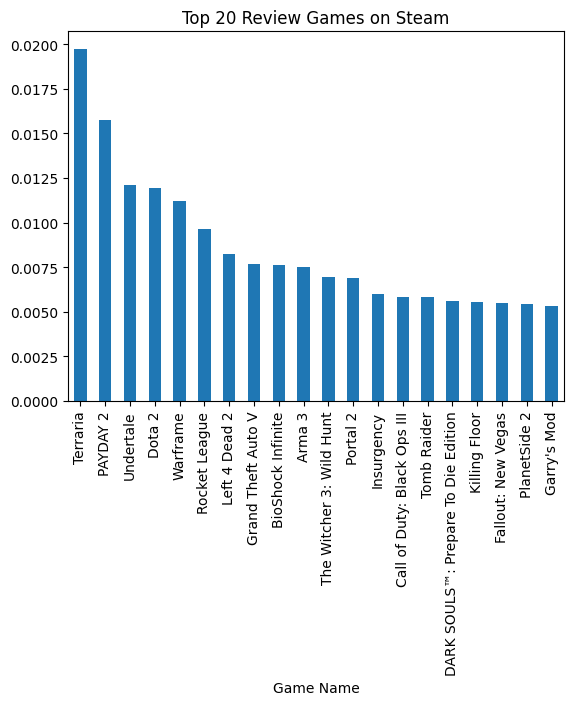

In [8]:
data["app_name"].value_counts(normalize=True).head(20).plot(kind="bar")
plt.xlabel("Game Name")
plt.title("Top 20 Review Games on Steam")
plt.show()

In [9]:
# remove rows without any data in processed review
data = data[~data["review_processed"].isnull()].copy(deep=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195452 entries, 0 to 195563
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   app_id            195452 non-null  int64 
 1   app_name          195452 non-null  object
 2   review_text       195452 non-null  object
 3   review_score      195452 non-null  int64 
 4   review_votes      195452 non-null  int64 
 5   review_processed  195452 non-null  object
dtypes: int64(3), object(3)
memory usage: 10.4+ MB


## Data Processing and Modeling: Pipelines and GridSearchCV

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
# import lightgbm as lgbm
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [12]:
# function to show results
def show_metrics(y_test, predictions):
    print("Confusion Matrix: ")
    cmat = metrics.confusion_matrix(y_test, predictions)
    print(cmat)
    print("True Positives (TP) = ", cmat[0,0])
    print("True Negatives (TN) = ", cmat[1,1])
    print("False Positives (FP) = ", cmat[0,1])
    print("False Negatives (FN) = ", cmat[1,0])
    print("Accuracy: ")
    print(metrics.accuracy_score(y_test, predictions))
    print("Precision: ")
    print(metrics.precision_score(y_test, predictions))
    print("F1 Score: ")
    print(metrics.f1_score(y_test, predictions))
    print("Classification Report: ")
    print(metrics.classification_report(y_test, predictions))

In [13]:
X = data["review_processed"]
y = data["review_score"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [15]:
pipe = Pipeline([("cvector", CountVectorizer()), 
                 ("tfidf", TfidfTransformer())
                ])

X_train_tfvec = pipe.fit_transform(X_train)

X_test_tfvec = pipe.transform(X_test)

print("Training Data Shape: ")
X_train_tfvec.shape

Training Data Shape: 


(156361, 91863)

## Logistic Regression

In [16]:
%%time
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_tfvec, y_train)

lr_pred = lr.predict(X_test_tfvec)

print("Logistic Regression: ")
lr_train = lr.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, lr_train))

show_metrics(y_test, lr_pred)

Logistic Regression: 
Training Accuracy:  0.9046693229130026
Confusion Matrix: 
[[ 3318  3260]
 [  970 31543]]
True Positives (TP) =  3318
True Negatives (TN) =  31543
False Positives (FP) =  3260
False Negatives (FN) =  970
Accuracy: 
0.8917909493233737
Precision: 
0.906329914087866
F1 Score: 
0.9371620417137085
Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.50      0.61      6578
           1       0.91      0.97      0.94     32513

    accuracy                           0.89     39091
   macro avg       0.84      0.74      0.77     39091
weighted avg       0.88      0.89      0.88     39091

CPU times: user 33.8 s, sys: 34.7 s, total: 1min 8s
Wall time: 18 s


In [17]:
%%time
# tuning with gridsearch
param_grid = {"C": [0.01, 0.1, 1, 10], 
              "solver": ["newton-cg", "lbfgs", "liblinear"]}

lr_cv = GridSearchCV(lr, param_grid, cv=5)
lr_cv.fit(X_train_tfvec, y_train)

print("Best Params: ", lr_cv.best_params_)
print("Best Score: ", lr_cv.best_score_)

Best Params:  {'C': 1, 'solver': 'lbfgs'}
Best Score:  0.892556312629116
CPU times: user 19min 5s, sys: 17min 43s, total: 36min 48s
Wall time: 9min 41s


In [18]:
new_lr = LogisticRegression(max_iter=2000, random_state=42, **lr_cv.best_params_)
new_lr.fit(X_train_tfvec, y_train)

lr_pred = new_lr.predict(X_test_tfvec)

lr_train = new_lr.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, lr_train))

show_metrics(y_test, lr_pred)

Training Accuracy:  0.9046693229130026
Confusion Matrix: 
[[ 3318  3260]
 [  970 31543]]
True Positives (TP) =  3318
True Negatives (TN) =  31543
False Positives (FP) =  3260
False Negatives (FN) =  970
Accuracy: 
0.8917909493233737
Precision: 
0.906329914087866
F1 Score: 
0.9371620417137085
Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.50      0.61      6578
           1       0.91      0.97      0.94     32513

    accuracy                           0.89     39091
   macro avg       0.84      0.74      0.77     39091
weighted avg       0.88      0.89      0.88     39091



## Decision Tree

In [19]:
%%time
dtc_clf = DecisionTreeClassifier(random_state=42)
dtc_clf.fit(X_train_tfvec, y_train)

dtc_pred = dtc_clf.predict(X_test_tfvec)

print("Decision Tree: ")
dtc_train = dtc_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, dtc_train))

show_metrics(y_test, dtc_pred)

Decision Tree: 
Training Accuracy:  0.9976144946629915
Confusion Matrix: 
[[ 2793  3785]
 [ 3167 29346]]
True Positives (TP) =  2793
True Negatives (TN) =  29346
False Positives (FP) =  3785
False Negatives (FN) =  3167
Accuracy: 
0.8221585531196439
Precision: 
0.8857565422112221
F1 Score: 
0.8940954238011092
Classification Report: 
              precision    recall  f1-score   support

           0       0.47      0.42      0.45      6578
           1       0.89      0.90      0.89     32513

    accuracy                           0.82     39091
   macro avg       0.68      0.66      0.67     39091
weighted avg       0.82      0.82      0.82     39091

CPU times: user 6min 5s, sys: 156 ms, total: 6min 5s
Wall time: 6min 5s


In [20]:
%%time
# tuning with gridsearch
param_grid = {"max_depth": [2, 5, 8, 12, 18], 
              "min_samples_leaf": [5, 10, 20, 35, 60], 
              "criterion": ["gini", "entropy"]}

dtc_cv = GridSearchCV(dtc_clf, param_grid, cv=5)
dtc_cv.fit(X_train_tfvec, y_train)

print("Best Params: ", dtc_cv.best_params_)
print("Best Score: ", dtc_cv.best_score_)

Best Params:  {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 60}
Best Score:  0.851676555975498
CPU times: user 1h 22min 44s, sys: 1.29 s, total: 1h 22min 46s
Wall time: 1h 22min 47s


In [21]:
new_dtc = DecisionTreeClassifier(random_state=42, **dtc_cv.best_params_)
new_dtc.fit(X_train_tfvec, y_train)

dtc_pred = new_dtc.predict(X_test_tfvec)

dtc_train = new_dtc.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, dtc_train))

show_metrics(y_test, dtc_pred)

Training Accuracy:  0.8586092439930674
Confusion Matrix: 
[[ 1837  4741]
 [ 1166 31347]]
True Positives (TP) =  1837
True Negatives (TN) =  31347
False Positives (FP) =  4741
False Negatives (FN) =  1166
Accuracy: 
0.8488910490905835
Precision: 
0.8686266903125692
F1 Score: 
0.913893383478375
Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.28      0.38      6578
           1       0.87      0.96      0.91     32513

    accuracy                           0.85     39091
   macro avg       0.74      0.62      0.65     39091
weighted avg       0.83      0.85      0.82     39091



## Random Forest

In [22]:
%%time
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_tfvec, y_train)

rf_pred = rf_clf.predict(X_test_tfvec)

print("Random Forest: ")
rf_train = rf_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, rf_train))

show_metrics(y_test, rf_pred)

Random Forest: 
Training Accuracy:  0.9976144946629915
Confusion Matrix: 
[[ 1307  5271]
 [  307 32206]]
True Positives (TP) =  1307
True Negatives (TN) =  32206
False Positives (FP) =  5271
False Negatives (FN) =  307
Accuracy: 
0.8573073085876545
Precision: 
0.859353736958668
F1 Score: 
0.9203029004143449
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.20      0.32      6578
           1       0.86      0.99      0.92     32513

    accuracy                           0.86     39091
   macro avg       0.83      0.59      0.62     39091
weighted avg       0.85      0.86      0.82     39091

CPU times: user 26min 27s, sys: 1.08 s, total: 26min 28s
Wall time: 26min 28s


In [23]:
%%time
# tuning with gridsearch
param_grid = {"max_depth": [2, 5, 8, 12, 18], 
              "min_samples_leaf": [5, 10, 20, 35, 60], 
              "n_estimators": [30, 50, 80, 150]}

rf_cv = GridSearchCV(rf_clf, param_grid, cv=5)
rf_cv.fit(X_train_tfvec, y_train)

print("Best Params: ", rf_cv.best_params_)
print("Best Score: ", rf_cv.best_score_)

Best Params:  {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 30}
Best Score:  0.8319849580220342
CPU times: user 3h 45s, sys: 13.2 s, total: 3h 58s
Wall time: 3h 1min


In [24]:
new_rf = RandomForestClassifier(random_state=42, **rf_cv.best_params_)
new_rf.fit(X_train_tfvec, y_train)

rf_pred = new_rf.predict(X_test_tfvec)

rf_train = new_rf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, rf_train))

show_metrics(y_test, rf_pred)

Training Accuracy:  0.8319849578859179
Confusion Matrix: 
[[    0  6578]
 [    0 32513]]
True Positives (TP) =  0
True Negatives (TN) =  32513
False Positives (FP) =  6578
False Negatives (FN) =  0
Accuracy: 
0.831725972730296
Precision: 
0.831725972730296
F1 Score: 
0.9081336238198984
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6578
           1       0.83      1.00      0.91     32513

    accuracy                           0.83     39091
   macro avg       0.42      0.50      0.45     39091
weighted avg       0.69      0.83      0.76     39091



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost

In [25]:
%%time
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_tfvec, y_train)

xgb_pred = xgb_clf.predict(X_test_tfvec)

print("XGBoost: ")
xgb_train = xgb_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, xgb_train))

show_metrics(y_test, xgb_pred)

XGBoost: 
Training Accuracy:  0.8995721439489387
Confusion Matrix: 
[[ 2513  4065]
 [  781 31732]]
True Positives (TP) =  2513
True Negatives (TN) =  31732
False Positives (FP) =  4065
False Negatives (FN) =  781
Accuracy: 
0.8760328464352408
Precision: 
0.8864429980165935
F1 Score: 
0.9290587029717464
Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.38      0.51      6578
           1       0.89      0.98      0.93     32513

    accuracy                           0.88     39091
   macro avg       0.82      0.68      0.72     39091
weighted avg       0.87      0.88      0.86     39091

CPU times: user 4min, sys: 1.28 s, total: 4min 1s
Wall time: 1min 16s


## Naive Bayes

In [26]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfvec, y_train)

nb_pred = clf.predict(X_test_tfvec)

print("Naive Bayes: ")
nb_train = clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, nb_train))

show_metrics(y_test, nb_pred)

Naive Bayes: 
Training Accuracy:  0.8418915202640045
Confusion Matrix: 
[[  207  6371]
 [   25 32488]]
True Positives (TP) =  207
True Negatives (TN) =  32488
False Positives (FP) =  6371
False Negatives (FN) =  25
Accuracy: 
0.8363817758563352
Precision: 
0.8360482771044031
F1 Score: 
0.9103850249397523
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.03      0.06      6578
           1       0.84      1.00      0.91     32513

    accuracy                           0.84     39091
   macro avg       0.86      0.52      0.49     39091
weighted avg       0.85      0.84      0.77     39091

CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 230 ms


## K Nearest Neighbors

## LightGBM

In [27]:
# takes a long time and needs more refining
# %%time
# lgb_clf = lgbm.LGBMClassifier(random_state=42)
# lgb_clf.fit(X_train_tfvec, y_train)

# lgb_pred = lgb_clf.predict(X_test_tfvec)

# lgb_train = lgb_clf.predict(X_train_tfvec)
# print("Training Accuracy: ", metrics.accuracy_score(y_train, lgb_train))

# show_metrics(y_test, lgb_pred)

In [28]:
# %%time
# # tuning with gridsearch
# param_grid = {"n_estimators": [50, 100, 150, 200], 
#               "learning_rate": [0.001, 0.01, 0.1, 1], 
#               "boosting_type": ["gbdt", "dart", "rf"]}

# lgb_cv = GridSearchCV(lgb_clf, param_grid, cv=5)
# lgb_cv.fit(X_train_tfvec, y_train)

# print("Best Params: ", lgb_cv.best_params_)
# print("Best Score: ", lgb_cv.best_score_)

## AdaBoost

In [29]:
%%time
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train_tfvec, y_train)

ada_pred = ada.predict(X_test_tfvec)

print("AdaBoost: ")
ada_train = ada.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, ada_train))

show_metrics(y_test, ada_pred)

AdaBoost: 
Training Accuracy:  0.8621523269869085
Confusion Matrix: 
[[ 1987  4591]
 [  940 31573]]
True Positives (TP) =  1987
True Negatives (TN) =  31573
False Positives (FP) =  4591
False Negatives (FN) =  940
Accuracy: 
0.8585096313729503
Precision: 
0.8730505475058069
F1 Score: 
0.9194635758696507
Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.30      0.42      6578
           1       0.87      0.97      0.92     32513

    accuracy                           0.86     39091
   macro avg       0.78      0.64      0.67     39091
weighted avg       0.84      0.86      0.84     39091

CPU times: user 1min 13s, sys: 10.1 ms, total: 1min 13s
Wall time: 1min 13s


In [30]:
%%time
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train_tfvec, y_train)

ada_pred = ada.predict(X_test_tfvec)

print("AdaBoost 100: ")
ada_train = ada.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, ada_train))

show_metrics(y_test, ada_pred)

AdaBoost 100: 
Training Accuracy:  0.8695262885246321
Confusion Matrix: 
[[ 2311  4267]
 [ 1007 31506]]
True Positives (TP) =  2311
True Negatives (TN) =  31506
False Positives (FP) =  4267
False Negatives (FN) =  1007
Accuracy: 
0.8650840346882914
Precision: 
0.8807200961619098
F1 Score: 
0.922766013531324
Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.35      0.47      6578
           1       0.88      0.97      0.92     32513

    accuracy                           0.87     39091
   macro avg       0.79      0.66      0.69     39091
weighted avg       0.85      0.87      0.85     39091

CPU times: user 2min 35s, sys: 34.2 ms, total: 2min 35s
Wall time: 2min 35s


In [31]:
%%time
ada = AdaBoostClassifier(n_estimators=150, random_state=42)
ada.fit(X_train_tfvec, y_train)

ada_pred = ada.predict(X_test_tfvec)

print("AdaBoost 150: ")
ada_train = ada.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, ada_train))

show_metrics(y_test, ada_pred)

AdaBoost 150: 
Training Accuracy:  0.8759153497355479
Confusion Matrix: 
[[ 2587  3991]
 [ 1072 31441]]
True Positives (TP) =  2587
True Negatives (TN) =  31441
False Positives (FP) =  3991
False Negatives (FN) =  1072
Accuracy: 
0.870481696554194
Precision: 
0.8873617069315872
F1 Score: 
0.9254838472293766
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.39      0.51      6578
           1       0.89      0.97      0.93     32513

    accuracy                           0.87     39091
   macro avg       0.80      0.68      0.72     39091
weighted avg       0.86      0.87      0.85     39091

CPU times: user 3min 54s, sys: 50.5 ms, total: 3min 54s
Wall time: 3min 54s


In [32]:
# GridSearch warnings
# /opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: 
# UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 
# Use `zero_division` parameter to control this behavior.
# _warn_prf(average, modifier, msg_start, len(result))

In [33]:
# timeout before results came
# %%time
# # tuning with gridsearch
# param_grid = {"n_estimators" : [50, 70, 90, 110, 140, 180], 
#               "learning_rate" : [0.001, 0.01, 0.1, 1, 10]}

# ada_cv = GridSearchCV(ada, param_grid, cv=5)
# ada_cv.fit(X_train_tfvec, y_train)

# print("Best Params: ", ada_cv.best_params_)
# print("Best Score: ", ada_cv.best_score_)

In [34]:
# new_ada = AdaBoostClassifier(random_state=42, **ada_cv.best_params_)
# new_ada.fit(X_train_tfvec, y_train)

# ada_pred = new_ada.predict(X_test_tfvec)

# ada_train = new_ada.predict(X_train_tfvec)
# print("Training Accuracy: ", metrics.accuracy_score(y_train, ada_train))

# show_metrics(y_test, ada_pred)

In [35]:
# %%time
# # use svc as a base learner
# svc = SVC(probability=True, kernel="linear", random_state=42)

# ada_svc = AdaBoostClassifier(base_estimator=svc, random_state=42)
# ada_svc.fit(X_train_tfvec, y_train)

# ada_svc_pred = ada_svc.predict(X_test_tfvec)

# show_metrics(y_test, ada_svc_pred)